In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
directory = os.path.abspath("") + '/dataset/xrp/'
data = pd.read_csv(directory + 'data.csv', on_bad_lines = 'skip')
ECDSA = data.copy()
ECDSA = ECDSA.drop_duplicates(subset=['BlockNo'])
ECDSA = ECDSA.sort_values(by='BlockNo')

In [3]:
# Drop blocks with no transactions
ECDSA = ECDSA[ECDSA['TotalTx'] != 0]

ECDSA['AvgTxSize'] = ECDSA['BlockSize'] / ECDSA['TotalTx']

ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))

ECDSA['AvgFeePerTx'] = ECDSA['TotalFees'] / ECDSA['TotalTx']

# The current minimum transaction cost required by the network for a standard transaction is 0.00001 XRP (10 drops). 
ECDSA['AvgLoadFee'] = ECDSA['AvgFeePerTx'] / 0.00001

ECDSA['BlockTime'] = ECDSA['Timestamp'].diff()

ECDSA['BlockTime'] = ECDSA['BlockTime'] / 100

# Drop blocks with zero
ECDSA = ECDSA[ECDSA['BlockTime'] != 0]

ECDSA['AverageTPS'] = (ECDSA['BlockSize'] / ECDSA['AvgTxSize']) / ECDSA['BlockTime']

ECDSA.describe()

C:\Users\ummar\AppData\Local\Temp\ipykernel_4588\3314511187.py:6: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))


,BlockNo,TotalTx,TotalFees,Timestamp,BlockSize,AvgTxSize,Date,AvgFeePerTx,AvgLoadFee,BlockTime,AverageTPS
count,8.731800e+04,87318.000000,87318.000000,8.731800e+04,8.731800e+04,87318.000000,87318,87318.000000,87318.000000,87317.000000,87317.000000
mean,8.138793e+07,66.874654,0.134041,1.690269e+09,1.802477e+05,2911.961266,2023-07-25 07:18:03.546233344,0.002604,260.364153,3.896351,17.114661
min,7.700010e+07,6.000000,0.000097,1.673267e+09,1.477200e+04,1444.825581,2023-01-09 12:15:41,0.000011,1.077778,3.520000,1.069519
25%,7.919022e+07,38.000000,0.002651,1.681831e+09,1.120278e+05,2685.806091,2023-04-18 15:18:29.249999872,0.000046,4.645599,3.810000,9.768638
50%,8.137845e+07,50.000000,0.010877,1.690263e+09,1.505725e+05,2904.577352,2023-07-25 05:37:26.500000,0.000201,20.086773,3.890000,13.065327
75%,8.358748e+07,71.000000,0.032387,1.698722e+09,2.141608e+05,3103.968344,2023-10-31 03:09:52.750000128,0.000549,54.922415,3.900000,18.205128
max,8.580000e+07,624.000000,100.020601,1.707288e+09,4.224617e+06,17721.000000,2024-02-07 06:45:10,2.439527,243952.685366,23.290000,155.610973
std,2.538912e+06,53.394110,0.690830,9.784427e+06,1.178616e+05,594.689928,NaN,0.015624,1562.412509,0.414207,13.440191


In the XRP Ledger, transaction fees are not directly determined by transaction size, as is the case with some other blockchain networks like Bitcoin. Instead, XRP Ledger transactions have a fixed base fee (0.00001 XRP per transaction)

However, the XRP Ledger employs a mechanism called transaction cost or "Reserve Requirement" which is a minimum amount of XRP required to be held in an account to cover the costs of maintaining that account in the ledger. 

This reserve requirement is determined by the size of the data an account has in the ledger (including trust lines and objects), not the size of the transactions themselves.

So, while the size of a transaction can indirectly affect the total cost of using the XRP Ledger (as it may impact the account's reserve requirement), the primary factor affecting the fee is the fixed base fee per transaction.

Text(0.5, 1.0, 'XRP correlation between features')

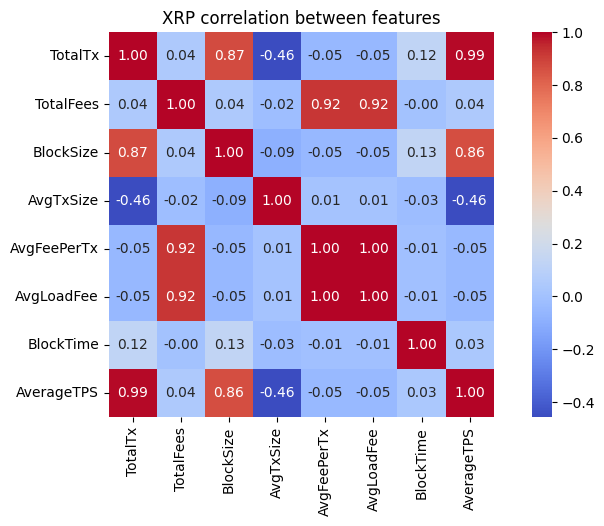

In [4]:
ECDSA_CORR = ECDSA.copy().drop(labels=['BlockNo','Timestamp', 'Date'], axis=1).corr()
plt.figure(figsize=(10,5))
sns.heatmap(ECDSA_CORR, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.title('XRP correlation between features')

In [5]:
def getPQAvgTransactionSize(ECDSATxSize, PQ_SIG_SIZE: int):
    
    # ECDSA (bytes)
    ECDSA_SIG_SIZE = 64

    PQ_TxSize = ECDSATxSize - ECDSA_SIG_SIZE + PQ_SIG_SIZE

    return PQ_TxSize

In [6]:
FALCON_512_SIG_SIZE = 666 # (bytes)

FALCON = pd.DataFrame()

FALCON['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], FALCON_512_SIG_SIZE)

Ts = ECDSA['TotalTx'].mean() / (176.55 / (FALCON['AvgTxSize'].mean() / 50))

Tv = ECDSA['TotalTx'].mean() / (17234 / (FALCON['AvgTxSize'].mean() / 50))

FALCON['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

FALCON['Power'] = FALCON['Power'] / 3.6e6

FALCON['Date'] = ECDSA['Date']

FALCON.describe()

,AvgTxSize,Power,Date
count,87318.000000,87318.000000,87318
mean,3513.961266,34.786283,2023-07-25 07:18:03.546233344
min,2046.825581,34.786283,2023-01-09 12:15:41
25%,3287.806091,34.786283,2023-04-18 15:18:29.249999872
50%,3506.577352,34.786283,2023-07-25 05:37:26.500000
75%,3705.968344,34.786283,2023-10-31 03:09:52.750000128
max,18323.000000,34.786283,2024-02-07 06:45:10
std,594.689928,0.000000,NaN


In [7]:
DILITHIUM_SIG_SIZE = 2420 # (bytes)

DILITHIUM = pd.DataFrame()

DILITHIUM['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], DILITHIUM_SIG_SIZE)

Ts = ECDSA['TotalTx'].mean() / (2125 / (DILITHIUM['AvgTxSize'].mean() / 50))

Tv = ECDSA['TotalTx'].mean() / (8826 / (DILITHIUM['AvgTxSize'].mean() / 50))

DILITHIUM['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

DILITHIUM['Power'] = DILITHIUM['Power'] / 3.6e6

DILITHIUM['Date'] = ECDSA['Date']

DILITHIUM.describe()

,AvgTxSize,Power,Date
count,87318.000000,8.731800e+04,87318
mean,5267.961266,5.321400e+00,2023-07-25 07:18:03.546233344
min,3800.825581,5.321400e+00,2023-01-09 12:15:41
25%,5041.806091,5.321400e+00,2023-04-18 15:18:29.249999872
50%,5260.577352,5.321400e+00,2023-07-25 05:37:26.500000
75%,5459.968344,5.321400e+00,2023-10-31 03:09:52.750000128
max,20077.000000,5.321400e+00,2024-02-07 06:45:10
std,594.689928,1.776367e-15,NaN


In [8]:
SPHINCS_SIG_SIZE = 17088 # (bytes)

SPHINCS = pd.DataFrame()

SPHINCS['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], SPHINCS_SIG_SIZE)

Ts = ECDSA['TotalTx'].mean() / (23.84 / (SPHINCS['AvgTxSize'].mean() / 50))

Tv = ECDSA['TotalTx'].mean() / (402.53 / (SPHINCS['AvgTxSize'].mean() / 50))

SPHINCS['Power'] = 210 * (86400 / ECDSA['BlockTime'].mean()).__floor__() * (Ts + Tv)

SPHINCS['Power'] = SPHINCS['Power'] / 3.6e6

SPHINCS['Date'] = ECDSA['Date']

SPHINCS.describe()

,AvgTxSize,Power,Date
count,87318.000000,8.731800e+04,87318
mean,19935.961266,1.532398e+03,2023-07-25 07:18:03.546233344
min,18468.825581,1.532398e+03,2023-01-09 12:15:41
25%,19709.806091,1.532398e+03,2023-04-18 15:18:29.249999872
50%,19928.577352,1.532398e+03,2023-07-25 05:37:26.500000
75%,20127.968344,1.532398e+03,2023-10-31 03:09:52.750000128
max,34745.000000,1.532398e+03,2024-02-07 06:45:10
std,594.689928,2.273750e-13,NaN


#### AVERAGE TRANSACTIONS PER SECOND

> Average TPS = (Average Block Size / Average Transaction Size) / Average Block Time

In [9]:
FALCON['AverageTPS'] = (ECDSA['BlockSize'] / FALCON['AvgTxSize']) / ECDSA['BlockTime']
DILITHIUM['AverageTPS'] = (ECDSA['BlockSize'] / DILITHIUM['AvgTxSize']) / ECDSA['BlockTime']
SPHINCS['AverageTPS'] = (ECDSA['BlockSize'] / SPHINCS['AvgTxSize']) / ECDSA['BlockTime']

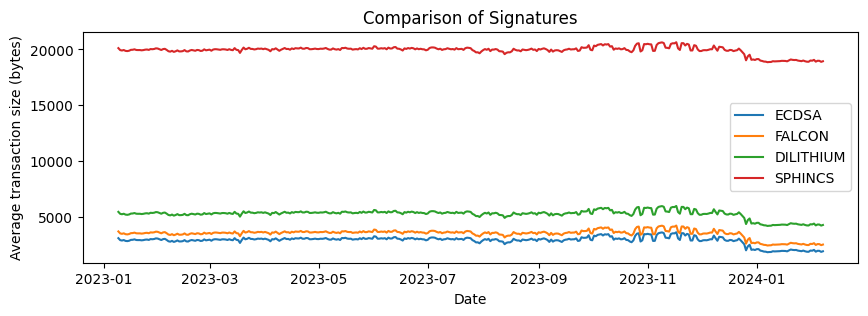

In [10]:
ECDSA_resampled = ECDSA.resample('1d', on='Date').mean()
FALCON_resampled = FALCON.resample('1d', on='Date').mean()
DILITHIUM_resampled = DILITHIUM.resample('1d', on='Date').mean()
SPHINCS_resampled = SPHINCS.resample('1d', on='Date').mean()

plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgTxSize'], label='ECDSA')
plt.plot(FALCON_resampled['AvgTxSize'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgTxSize'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgTxSize'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transaction size (bytes)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

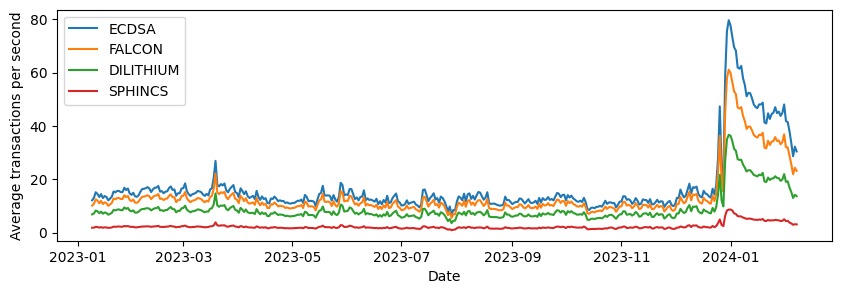

In [11]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AverageTPS'], label='ECDSA')
plt.plot(FALCON_resampled['AverageTPS'], label='FALCON')
plt.plot(DILITHIUM_resampled['AverageTPS'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AverageTPS'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transactions per second')
# plt.title('Comparison of Signatures')
plt.legend()
plt.show()

In [12]:
SPHINCS.describe()

,AvgTxSize,Power,Date,AverageTPS
count,87318.000000,8.731800e+04,87318,87317.000000
mean,19935.961266,1.532398e+03,2023-07-25 07:18:03.546233344,2.323965
min,18468.825581,1.532398e+03,2023-01-09 12:15:41,0.208091
25%,19709.806091,1.532398e+03,2023-04-18 15:18:29.249999872,1.456630
50%,19928.577352,1.532398e+03,2023-07-25 05:37:26.500000,1.939626
75%,20127.968344,1.532398e+03,2023-10-31 03:09:52.750000128,2.718067
max,34745.000000,1.532398e+03,2024-02-07 06:45:10,39.923557
std,594.689928,2.273750e-13,NaN,1.469724
